
# 📊 Logistics KPI Analysis and Redesign Evaluation

This Python script performs a detailed quantitative analysis of logistics performance data, focusing on evaluating the impact of process redesigns. It computes key performance indicators (KPIs), simulates improvements, and derives feature importance using both **Shapley values** and **AHP (Analytic Hierarchy Process)**.

## 📦 Features

* **Data Cleaning**: Handles inconsistent column names and missing or malformed numeric data.
* **KPI Calculation**: Computes logistics KPIs like delivery delay, rescheduling percentage, and crew efficiency.
* **Scenario Simulation**: Applies predefined improvement rates to simulate a post-intervention scenario.
* **Impact Analysis**: Quantifies KPI variations before and after redesign.
* **Shapley Weights**: Assigns importance scores to each KPI using Shapley value approximations.
* **AHP Weighting**: Offers an alternative, expert-driven weighting system via pairwise comparisons with consistency checking.

---

## ⚙️ Main Functions

| Function                                                           | Description                                                                             |
| ------------------------------------------------------------------ | --------------------------------------------------------------------------------------- |
| `clean_column_names(df)`                                           | Standardizes column names by removing symbols and trimming whitespace.                  |
| `clean_data(df)`                                                   | Converts strings to numeric, fills missing values, and handles locale-specific formats. |
| `apply_improvements(df, improvements)`                             | Applies relative KPI improvements to simulate a redesigned scenario.                    |
| `calculate_kpis(df)`                                               | Computes derived KPIs from raw operational metrics.                                     |
| `analyze_redesign(df_before, df_after)`                            | Compares before/after KPI performance and calculates Shapley weights.                   |
| `calculate_shapley_weights(improvements)`                          | Approximates Shapley values for KPI importance through sampling.                        |
| `build_ahp_weights(kpi_list, input_matrix=None, interactive=True)` | Builds and validates an AHP matrix, returning normalized weights and consistency ratio. |
| `format_results(results)`                                          | Formats analysis results into a human-readable table.                                   |

---

## 📈 KPIs Tracked

* `NumeroRisorse`: Crew resources assigned
* `NumeroConsegneEffettuate`: Deliveries per day
* `LeadTimeEfficiency`: Inverse delay relative to a 2h threshold
* `PercentualeFlessibili`: Flexibility from UPL (unit per load)
* `RitardoMedioConsegna`: Average delivery delay
* `CustomerSatisfaction`: Proxy from rescheduling frequency
* `PercentualeConsegneRiprogrammate`: Share of rescheduled deliveries

---

## 🧠 Weighting Methods

### 🔹 Shapley Values (Data-Driven)

Estimates KPI contributions using permutations and marginal improvements. Useful for understanding empirical impact.

### 🔸 AHP (Expert-Driven)

Supports pairwise KPI importance evaluation, calculates consistency ratio, and provides normalized weights.

---

## 🛠️ Usage

1. Place your CSV file as `dataset.csv` in the same directory.
2. Run the script to perform the redesign analysis:

```bash
python your_script_name.py
```

3. For AHP-based weighting:

```bash
python your_script_name.py  # interactive mode
```

Follow the prompts to enter pairwise comparisons for KPIs.

---

## 📌 Dependencies

* `pandas`
* `numpy`
* `tqdm`
* `logging`

Install via pip:

```bash
pip install pandas numpy tqdm
```

---

## 📝 Notes

* KPIs with negative improvement rates are considered "bad" (e.g., delay, rescheduling).
* The geometric mean is used for Shapley coalition valuation to preserve scale and handle multiplicative effects.
* AHP consistency ratio (CR) should ideally be < 0.1 for reliable judgments.

# 1. Loading dataset, computing Dataset To Be

In [ ]:
#TODO: load dataset, name of kpis and improvements of features 

#TODO: calculate KPI as is, using the dataset, and approximating the formulas 

#TODO: compute monte carlo with beta distribution and check is the KPI is the same for validity 

#TODO: change parameters of the beta distribution to make sure it reflects the changes in the features (list of improvements of features)) 

#TODO: compute monte carlo with beta distribution and compute new KPI 

#TODO: compute pct change between the two KPIs 

#TODO: min max scale for each KPI and assign a value to it (criteria, closest to) -1 -3 -5 +1 +3 +5

## second section 

#TODO: AHP on KPI, provide weights to each KPI

#TODO: SHAP-like analysis on the KPIs to understand how each KPI contributes and obtain weights for each KPI

#TODO: combine the weights from AHP and SHAP-like analysis to get a final weight for each KPI, AHP weights  contribute 70% and SHAP-like analysis contributes 30%

In [28]:
import numpy as np
import pandas as pd
from scipy.stats import beta
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple
import logging
import warnings

warnings.filterwarnings("ignore")

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [29]:

### --- PARAMETRI DA DEFINIRE --- ###
feature_improvements = {
    'Valore medio della merce consegnata in un giro [€/giro]': 0.05,
    '# giorni lavorati nel mese': 0.0,
    '# clienti  serviti nel mese': 0.06,
    'Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]': -0.40,
    '# consegne ripianificate per problemi nel TRASPORTO': -0.50,
    '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)': -0.30,
    '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)': -0.30,
    '# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)': -0.25,
    '# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)': -0.15
}

In [31]:
### --- STEP 1: Caricamento dataset --- ###
df = pd.read_csv("dataset.csv")  # oppure pd.read_csv se necessario

df.columns = [col.replace("\n", " ") for col in df.columns]
print(df.columns.tolist())

# Rimozione colonne inutili o vuote
df = df.drop(columns=["Unnamed: 14"], errors='ignore')

# Conversione numerica
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

print(df.info())

['Id', 'Mese', 'Id Equipaggio', 'UPL', 'Classe', 'Valore medio della merce consegnata in un giro [€/giro]', '# giorni lavorati nel mese', '# clienti  serviti nel mese', 'Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]', '# consegne ripianificate per problemi nel TRASPORTO', '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)', '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)', '# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)', '# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)', 'Unnamed: 14']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 14 columns):
 #   Column                                                                                                       Non-Null Count  Dtype  
---  ------                     

In [ ]:
### --- STEP 2: KPI As-Is --- ###
def compute_kpis(df: pd.DataFrame) -> Dict[str, float]:
    kpis = {
        "NumeroRisorse": df["Id Equipaggio"].nunique(),
        "NumeroConsegneEffettuate": df["# clienti  serviti nel mese"].sum() / df["# giorni lavorati nel mese"].sum(),
        "LeadTimeEfficiency": np.mean(np.maximum(120 - df["Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]"], 0)) / 120,
        "PercentualeFlessibili": (df["UPL"].value_counts(normalize=True).get("Flessibile", 0.0)),
        "RitardoMedioConsegna": df["Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]"].mean(),
        "CustomerSatisfaction": 1 - df["# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)"].sum() / len(df),
        "PercentualeConsegneRiprogrammate": df[
            ['# consegne ripianificate per problemi nel TRASPORTO',
             '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)',
             '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)',
             '# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)']
        ].sum().sum() / len(df)
    }
    return kpis

kpi_as_is = compute_kpis(df)
print("KPI As-Is:", kpi_as_is)

KPI As-Is: {'NumeroRisorse': 180, 'NumeroConsegneEffettuate': np.float64(3.7184656358659467), 'LeadTimeEfficiency': np.float64(0.962728581713463), 'PercentualeFlessibili': 0.0, 'RitardoMedioConsegna': np.float64(8.201511879049676), 'CustomerSatisfaction': np.float64(-1.8914362778152394), 'PercentualeConsegneRiprogrammate': np.float64(4.430883344571814)}


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

def monte_carlo_kpis(df: pd.DataFrame, n_iter: int = 1000) -> Tuple[Dict[str, float], Dict[str, List[float]]]:
    logger.info("Starting Monte Carlo simulation for As-Is KPIs with %d iterations...", n_iter)
    results = {k: [] for k in compute_kpis(df).keys()}

    for _ in range(n_iter):
        df_sampled = df.copy()
        for col in feature_improvements:
            if df_sampled[col].dtype in [np.float64, np.int64]:
                beta_sample = beta.rvs(2, 5, size=len(df_sampled))
                df_sampled[col] = df_sampled[col] * beta_sample
        kpis_sim = compute_kpis(df_sampled)
        for k, v in kpis_sim.items():
            results[k].append(v)

    monte_means = {k: np.mean(v) for k, v in results.items()}
    logger.info("Monte Carlo As-Is results: %s", monte_means)
    print("Monte Carlo As-Is KPI results:", monte_means)

    # --- Plot ---
    kpi_names = list(results.keys())
    n_kpis = len(kpi_names)
    n_cols = 2
    n_rows = (n_kpis + 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axs = axs.flatten()

    for ax, kpi in zip(axs, kpi_names):
        sns.histplot(results[kpi], bins=40, kde=True, stat="density", color="steelblue", ax=ax)
        ax.set_title(f"Distribuzione KPI As-Is: {kpi}", fontsize=12)
        ax.set_xlabel("Valore")
        ax.set_ylabel("Densità")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    return monte_means, results


In [74]:
def monte_carlo_tobe(df: pd.DataFrame, improvements: Dict[str, float], n_iter: int = 1000) -> Tuple[Dict[str, float], Dict[str, List[float]]]:
    logger.info("Starting Monte Carlo simulation for To-Be KPIs with %d iterations and improvements: %s", n_iter, improvements)

    def clean_column(series):
        if series.dtype == object:
            return pd.to_numeric(series.astype(str)
                                 .str.replace("€", "", regex=False)
                                 .str.replace(".", "", regex=False)
                                 .str.replace(",", ".", regex=False)
                                 .str.strip(), errors="coerce")
        return pd.to_numeric(series, errors="coerce")

    results = {k: [] for k in compute_kpis(df).keys()}

    for _ in range(n_iter):
        df_sampled = df.copy()
        for col, improvement in improvements.items():
            if col not in df_sampled.columns:
                logger.warning("Colonna '%s' non trovata nel dataframe. Skippata.", col)
                continue
            df_sampled[col] = clean_column(df_sampled[col])
            if df_sampled[col].isna().all():
                logger.warning("Colonna '%s' non contiene dati numerici validi. Skippata.", col)
                continue
            a = 2 + max(improvement * 10, 0)
            b = 5 - min(improvement * 10, 0)
            beta_sample = beta.rvs(a, b, size=len(df_sampled))
            df_sampled[col] = df_sampled[col].fillna(0) * beta_sample
        kpis_sim = compute_kpis(df_sampled)
        for k, v in kpis_sim.items():
            results[k].append(v)

    monte_means = {k: np.mean(v) for k, v in results.items()}
    logger.info("Monte Carlo To-Be results: %s", monte_means)
    print("Monte Carlo To-Be KPI results:")
    for k, v in monte_means.items():
        print(f"  {k:35s}: {v:.4f}")

    # --- Plot ---
    kpi_names = list(results.keys())
    n_kpis = len(kpi_names)
    n_cols = 2
    n_rows = (n_kpis + 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axs = axs.flatten()

    for ax, kpi in zip(axs, kpi_names):
        sns.histplot(results[kpi], bins=40, kde=True, stat="density", color="darkorange", ax=ax)
        ax.set_title(f"Distribuzione KPI To-Be: {kpi}", fontsize=12)
        ax.set_xlabel("Valore")
        ax.set_ylabel("Densità")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    return monte_means, results


2025-06-03 02:30:07,157 - INFO - Starting Monte Carlo simulation for As-Is KPIs with 1000 iterations...
2025-06-03 02:30:12,131 - INFO - Monte Carlo As-Is results: {'NumeroRisorse': np.float64(180.0), 'NumeroConsegneEffettuate': np.float64(3.7228913055466566), 'LeadTimeEfficiency': np.float64(0.9809648383153776), 'PercentualeFlessibili': np.float64(0.0), 'RitardoMedioConsegna': np.float64(2.3338444516869594), 'CustomerSatisfaction': np.float64(0.17377921796713933), 'PercentualeConsegneRiprogrammate': np.float64(1.265355510385586)}


Monte Carlo As-Is KPI results: {'NumeroRisorse': np.float64(180.0), 'NumeroConsegneEffettuate': np.float64(3.7228913055466566), 'LeadTimeEfficiency': np.float64(0.9809648383153776), 'PercentualeFlessibili': np.float64(0.0), 'RitardoMedioConsegna': np.float64(2.3338444516869594), 'CustomerSatisfaction': np.float64(0.17377921796713933), 'PercentualeConsegneRiprogrammate': np.float64(1.265355510385586)}


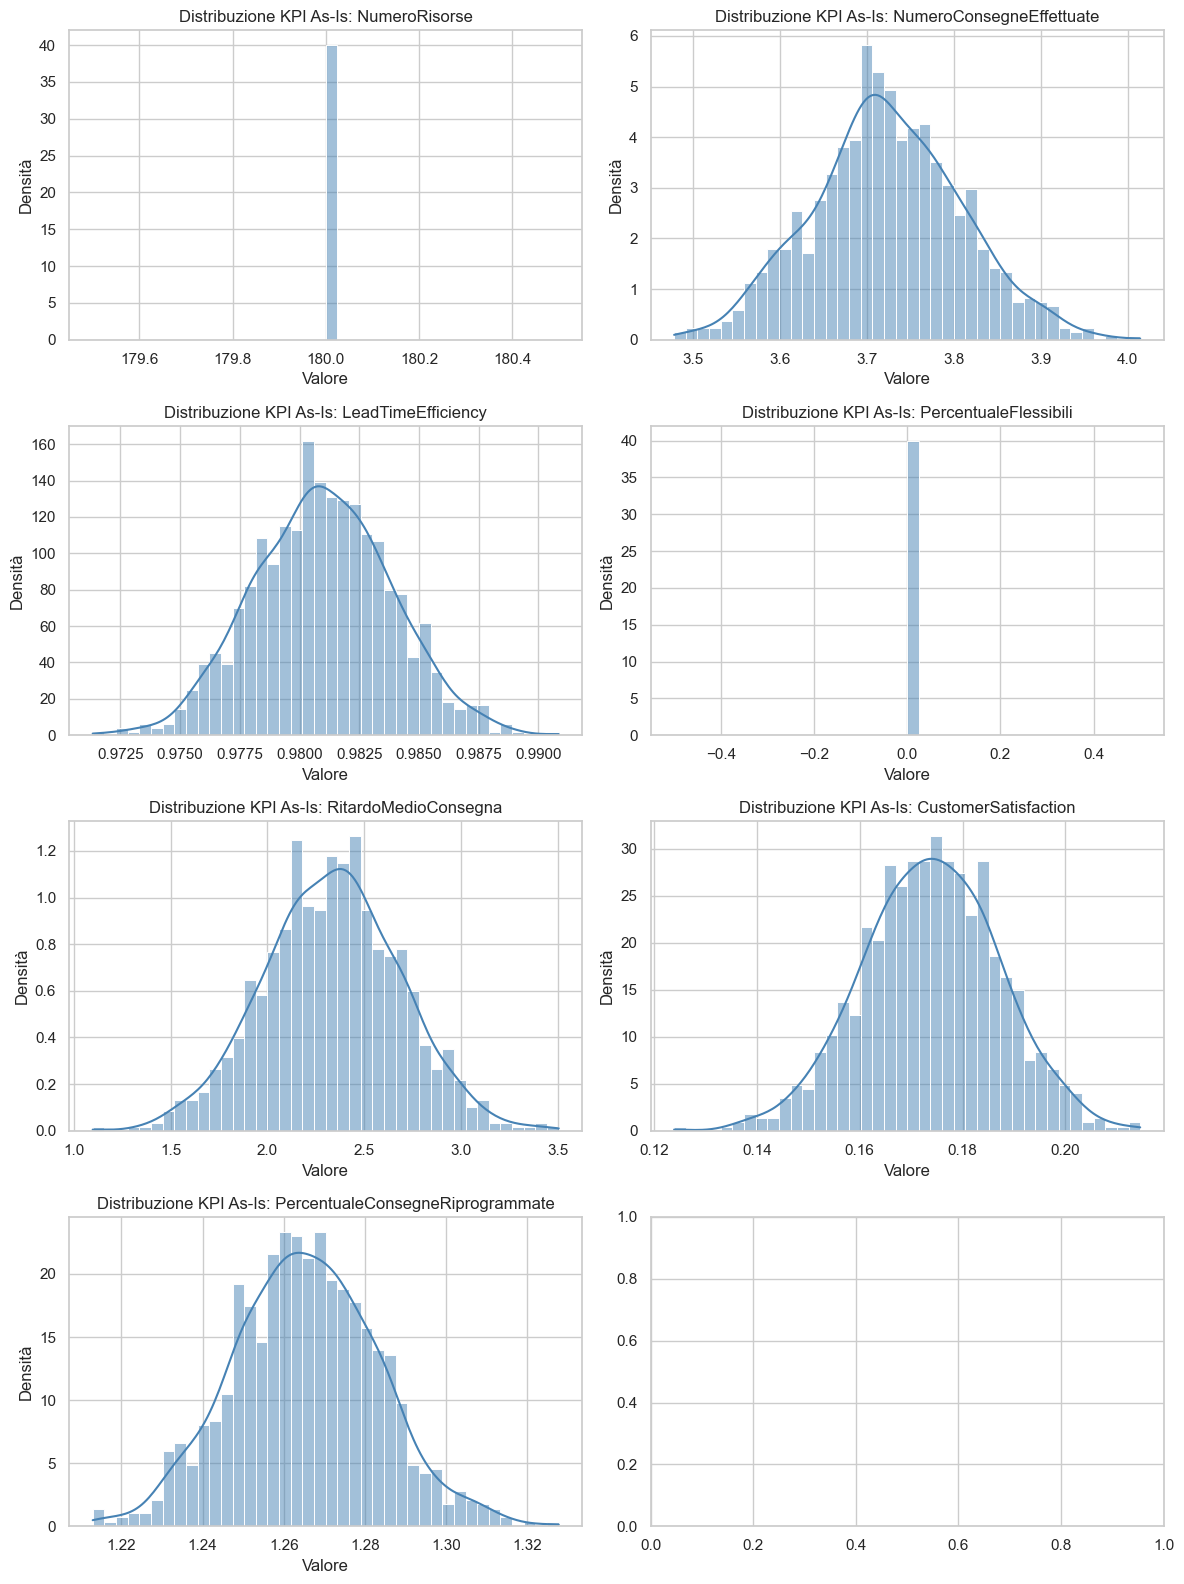

2025-06-03 02:30:13,801 - INFO - Starting Monte Carlo simulation for To-Be KPIs with 1000 iterations and improvements: {'Valore medio della merce consegnata in un giro [€/giro]': 0.05, '# giorni lavorati nel mese': 0.0, '# clienti  serviti nel mese': 0.06, 'Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]': -0.4, '# consegne ripianificate per problemi nel TRASPORTO': -0.5, '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)': -0.3, '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)': -0.3, '# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)': -0.25, '# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)': -0.15}
2025-06-03 02:30:21,003 - INFO - Monte Carlo To-Be results: {'NumeroRisorse': np.float64(180.0), 'NumeroConsegneEffettuate': np.float64(4.452156280696625), 'LeadTimeE

Monte Carlo To-Be KPI results:
  NumeroRisorse                      : 180.0000
  NumeroConsegneEffettuate           : 4.4522
  LeadTimeEfficiency                 : 0.9883
  PercentualeFlessibili              : 0.0000
  RitardoMedioConsegna               : 1.4057
  CustomerSatisfaction               : 0.3196
  PercentualeConsegneRiprogrammate   : 0.8309


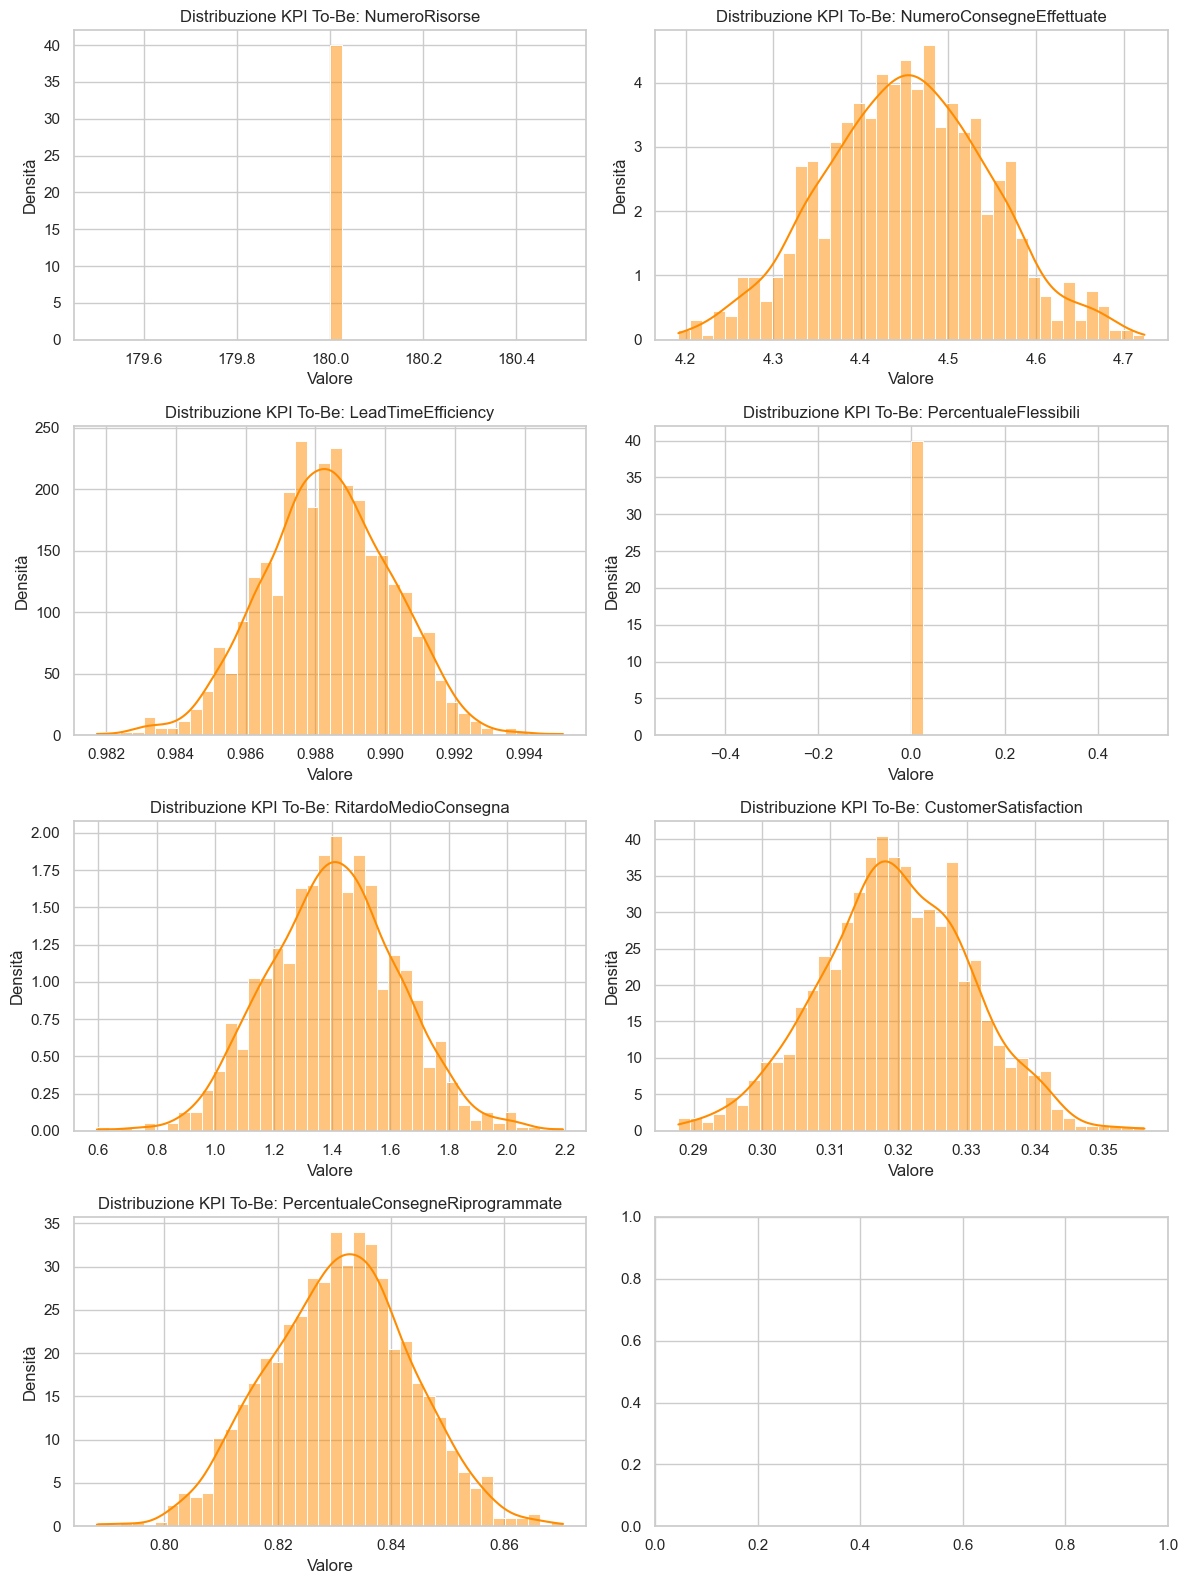

In [ ]:
monte_carlo_results, monte_carlo_data = monte_carlo_kpis(df)
monte_asis = monte_carlo_results

monte_tobe = monte_carlo_tobe(df, feature_improvements)


2025-06-03 02:34:40,024 - INFO - Starting Monte Carlo simulation for As-Is KPIs with 1000 iterations...
2025-06-03 02:34:44,326 - INFO - Monte Carlo As-Is results: {'NumeroRisorse': np.float64(180.0), 'NumeroConsegneEffettuate': np.float64(3.718338571667212), 'LeadTimeEfficiency': np.float64(0.9809399511464276), 'PercentualeFlessibili': np.float64(0.0), 'RitardoMedioConsegna': np.float64(2.334162638306473), 'CustomerSatisfaction': np.float64(0.17409947033919576), 'PercentualeConsegneRiprogrammate': np.float64(1.2658943301773014)}


Monte Carlo As-Is KPI results: {'NumeroRisorse': np.float64(180.0), 'NumeroConsegneEffettuate': np.float64(3.718338571667212), 'LeadTimeEfficiency': np.float64(0.9809399511464276), 'PercentualeFlessibili': np.float64(0.0), 'RitardoMedioConsegna': np.float64(2.334162638306473), 'CustomerSatisfaction': np.float64(0.17409947033919576), 'PercentualeConsegneRiprogrammate': np.float64(1.2658943301773014)}


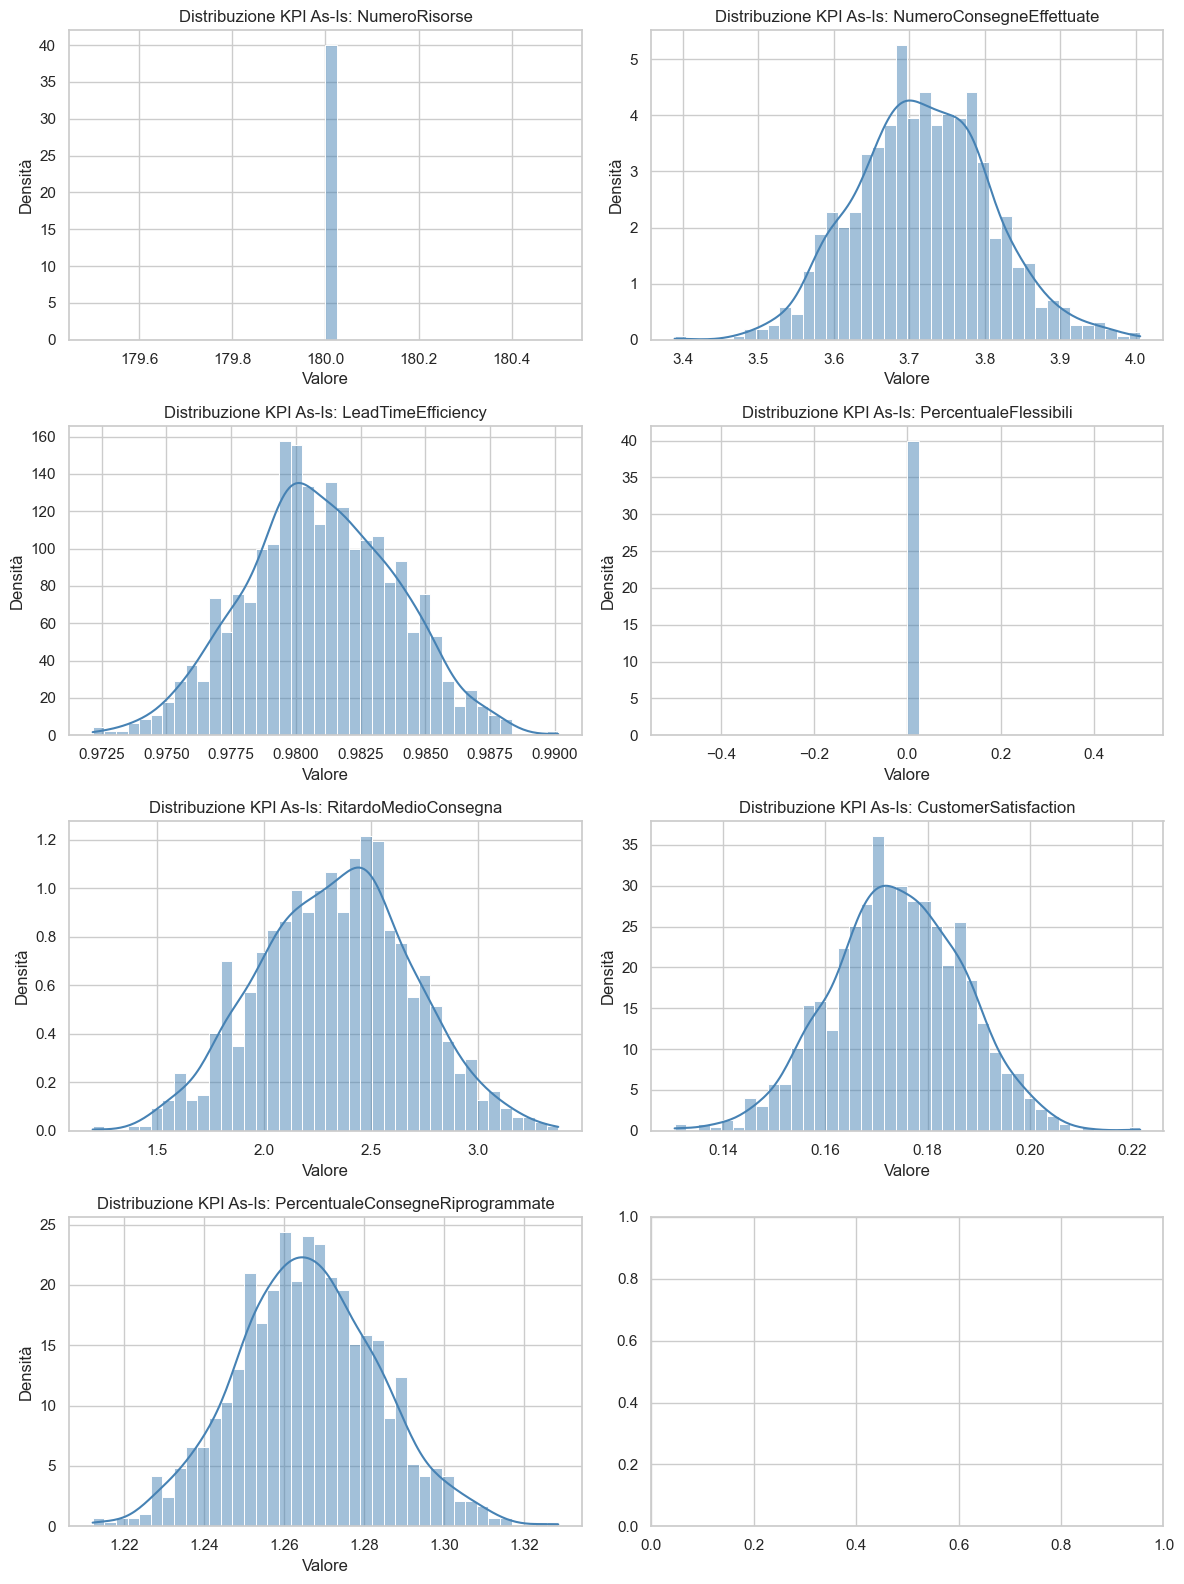

2025-06-03 02:34:45,356 - INFO - Starting Monte Carlo simulation for To-Be KPIs with 1000 iterations and improvements: {'Valore medio della merce consegnata in un giro [€/giro]': 0.05, '# giorni lavorati nel mese': 0.0, '# clienti  serviti nel mese': 0.06, 'Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]': -0.4, '# consegne ripianificate per problemi nel TRASPORTO': -0.5, '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)': -0.3, '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)': -0.3, '# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)': -0.25, '# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)': -0.15}
2025-06-03 02:34:53,211 - INFO - Monte Carlo To-Be results: {'NumeroRisorse': np.float64(180.0), 'NumeroConsegneEffettuate': np.float64(4.451368717643352), 'LeadTimeE

Monte Carlo To-Be KPI results:
  NumeroRisorse                      : 180.0000
  NumeroConsegneEffettuate           : 4.4514
  LeadTimeEfficiency                 : 0.9885
  PercentualeFlessibili              : 0.0000
  RitardoMedioConsegna               : 1.3873
  CustomerSatisfaction               : 0.3190
  PercentualeConsegneRiprogrammate   : 0.8309


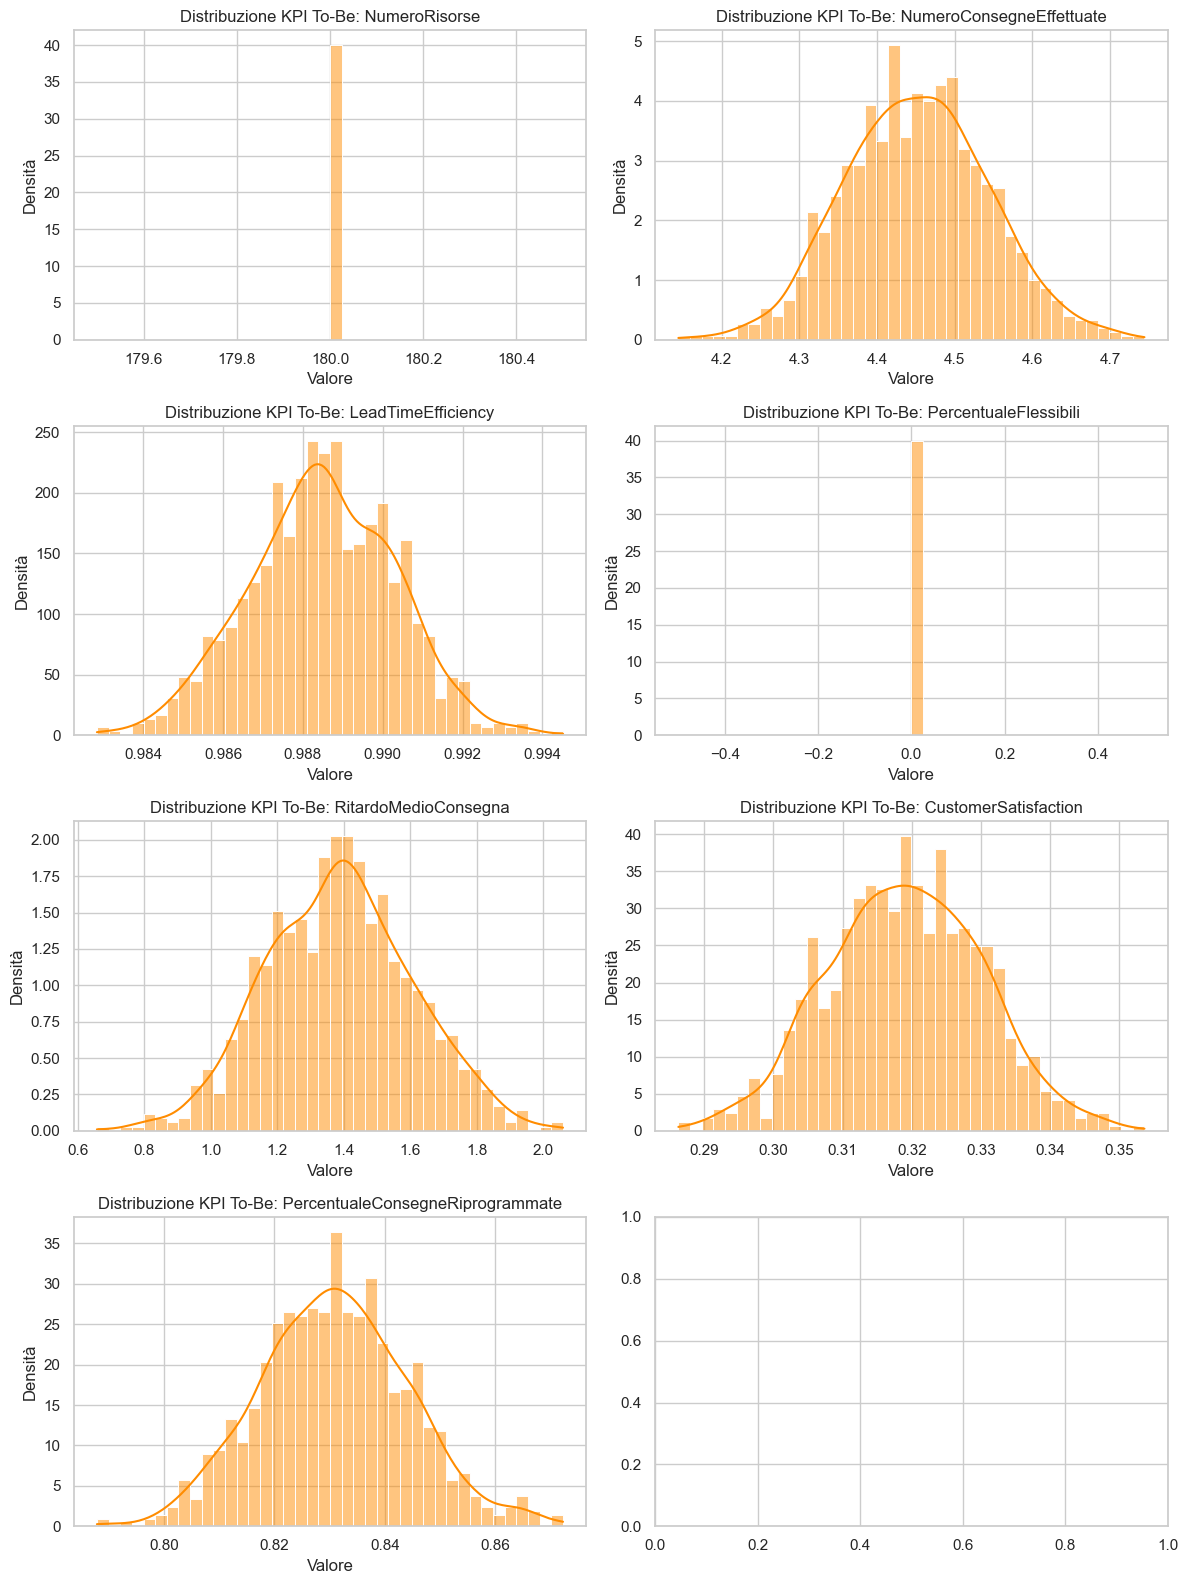

In [77]:
monte_asis_means, monte_asis_data = monte_carlo_kpis(df)
monte_tobe_means, monte_tobe_data = monte_carlo_tobe(df, feature_improvements)


Variazioni percentuali KPI (Δ%):
PercentualeFlessibili              : -nan%
CustomerSatisfaction               : +83.23%
RitardoMedioConsegna               : -40.57%
PercentualeConsegneRiprogrammate   : -34.36%
NumeroConsegneEffettuate           : +19.71%
LeadTimeEfficiency                 : +0.77%
NumeroRisorse                      : +0.00%


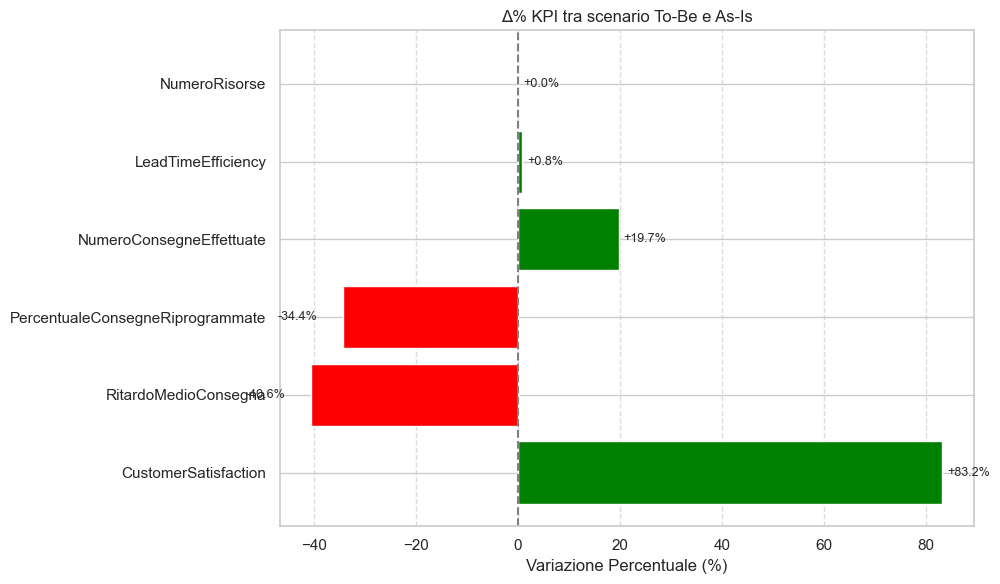

In [78]:
# --- STEP 6: Variazioni % --- #
delta_kpis = {
    k: (monte_tobe_means[k] - monte_asis_means[k]) / monte_asis_means[k]
    for k in monte_asis_means
}

# Ordina per variazione decrescente in valore assoluto
delta_kpis_sorted = dict(sorted(delta_kpis.items(), key=lambda x: abs(x[1]), reverse=True))

# --- Stampa migliorata --- #
print("Variazioni percentuali KPI (Δ%):")
for k, v in delta_kpis_sorted.items():
    sign = "+" if v >= 0 else "-"
    print(f"{k:35s}: {sign}{abs(v):.2%}")

# --- Plot --- #
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
kpi_names = list(delta_kpis_sorted.keys())
delta_values = [delta_kpis_sorted[k] * 100 for k in kpi_names]

bars = plt.barh(kpi_names, delta_values, color=["green" if v >= 0 else "red" for v in delta_values])
plt.axvline(x=0, color='gray', linestyle='--')
plt.title("Δ% KPI tra scenario To-Be e As-Is")
plt.xlabel("Variazione Percentuale (%)")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Etichette sui valori
for bar, val in zip(bars, delta_values):
    plt.text(bar.get_width() + (1 if val >= 0 else -5), 
             bar.get_y() + bar.get_height() / 2,
             f"{val:+.1f}%", va='center', ha='left' if val >= 0 else 'right', fontsize=9)

plt.show()


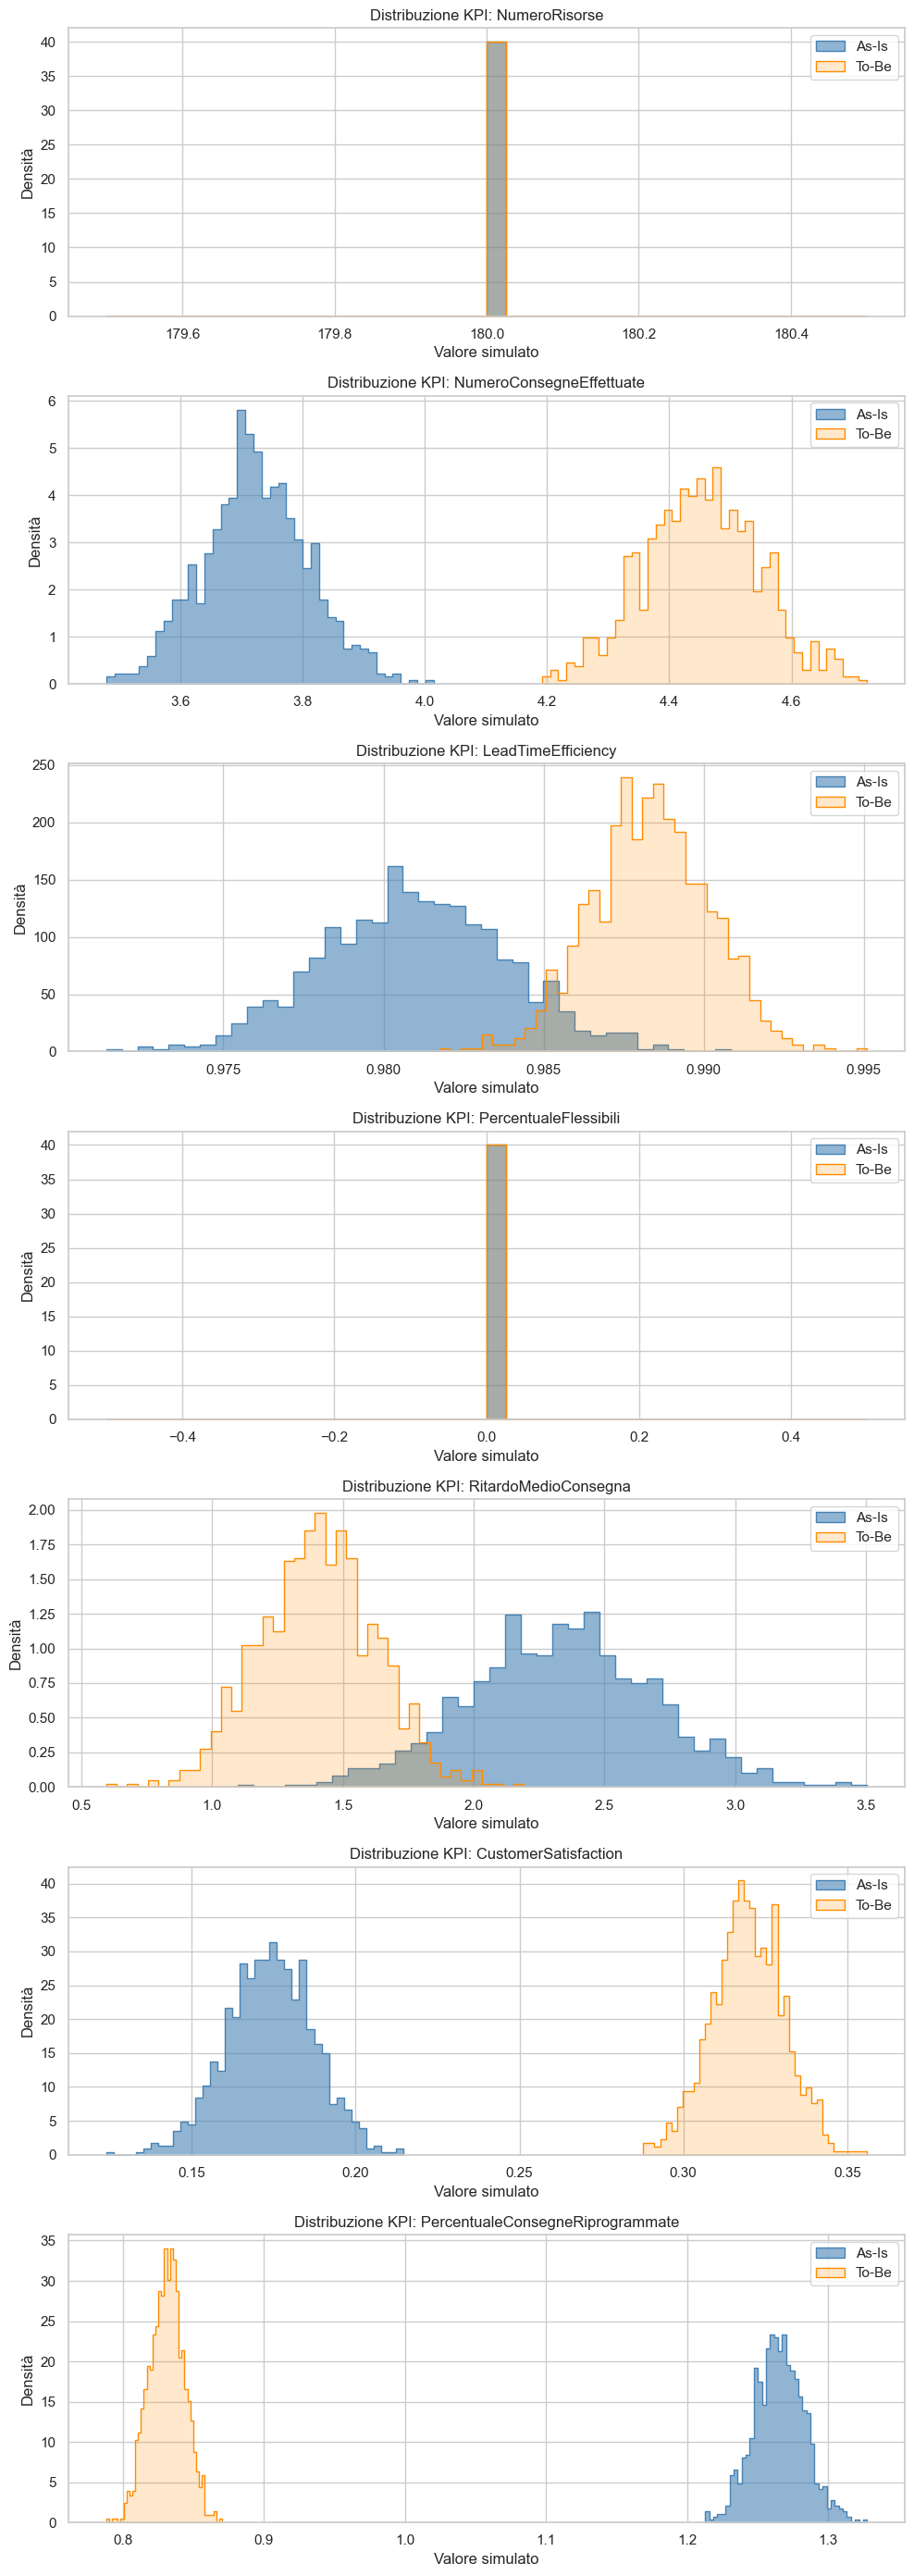

In [79]:
def plot_kpi_distributions_comparison(results_as_is, results_to_be, bins=40):
    """
    Plots each KPI’s Monte Carlo distribution for As-Is vs. To-Be on top of one another.

    Parameters:
    - results_as_is: dict of {kpi_name: list_of_values} for As-Is
    - results_to_be: dict of {kpi_name: list_of_values} for To-Be
    - bins: number of bins to use for both histograms (default: 40)
    """
    kpi_names = list(results_as_is.keys())
    num_kpis = len(kpi_names)

    fig, axs = plt.subplots(num_kpis, 1, figsize=(10, 4 * num_kpis), squeeze=False)

    for idx, kpi in enumerate(kpi_names):
        ax = axs[idx, 0]
        # Plot As-Is histogram as an outline
        sns.histplot(
            results_as_is[kpi],
            bins=bins,
            stat="density",
            element="step",
            fill=True,
            label="As-Is",
            color="steelblue",
            ax=ax,
            alpha=0.6
        )

        # Plot To-Be histogram as filled with low opacity
        sns.histplot(
            results_to_be[kpi],
            bins=bins,
            stat="density",
            element="step",
            fill=True,
            label="To-Be",
            color="darkorange",
            ax=ax,
            alpha=0.2  # low opacity
        )

        ax.set_title(f"Distribuzione KPI: {kpi}", fontsize=12)
        ax.set_xlabel("Valore simulato")
        ax.set_ylabel("Densità")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_kpi_distributions_comparison(monte_carlo_data, monte_tobe[1])



In [80]:
### --- STEP 7: Normalizzazione + Scoring Discreto --- ###
scaler = MinMaxScaler(feature_range=(-5, 5))
scaled = scaler.fit_transform(np.array(list(delta_kpis.values())).reshape(-1, 1)).flatten()
discrete_scores = {
    k: int(round(v)) if not np.isnan(v) else 0
    for k, v in zip(delta_kpis.keys(), scaled)
}

print("Punteggio (scalato e discretizzato):")
for k, v in discrete_scores.items():
    print(f"{k:35s}: {v:+d}")


Punteggio (scalato e discretizzato):
NumeroRisorse                      : -2
NumeroConsegneEffettuate           : +0
LeadTimeEfficiency                 : -2
PercentualeFlessibili              : +0
RitardoMedioConsegna               : -5
CustomerSatisfaction               : +5
PercentualeConsegneRiprogrammate   : -4


In [ ]:
### --- STEP 8: AHP (manual weights, es. mock) --- ###
ahp_weights = {
    'NumeroRisorse': 0.1,
    'NumeroConsegneEffettuate': 0.2,
    'LeadTimeEfficiency': 0.15,
    'PercentualeFlessibili': 0.1,
    'RitardoMedioConsegna': 0.15,
    'CustomerSatisfaction': 0.2,
    'PercentualeConsegneRiprogrammate': 0.1
}

In [ ]:
### --- STEP 9: SHAP-like analysis (semplificata) --- ###
def shap_like_weights(delta: Dict[str, float]) -> Dict[str, float]:
    total = sum(abs(v) for v in delta.values())
    return {k: abs(v) / total for k, v in delta.items()}

shap_weights = shap_like_weights(delta_kpis)

In [ ]:
### --- STEP 10: Fusione AHP + SHAP --- ###
final_weights = {
    k: 0.7 * ahp_weights[k] + 0.3 * shap_weights[k]
    for k in ahp_weights
}

logger.info("Final KPI Weights: %s", final_weights)
logger.info("Discrete Scores: %s", discrete_scores)


['Id', 'Mese', 'Id Equipaggio', 'UPL', 'Classe', 'Valore medio della merce consegnata in un giro [€/giro]', '# giorni lavorati nel mese', '# clienti  serviti nel mese', 'Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]', '# consegne ripianificate per problemi nel TRASPORTO', '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)', '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)', '# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)', '# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)', 'Unnamed: 14']


TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm import tqdm
import logging
import warnings
from scipy.stats import beta
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Any

warnings.filterwarnings('ignore')

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('kpi_analysis.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 15 columns):
 #   Column                                                                                                       Non-Null Count  Dtype  
---  ------                                                                                                       --------------  -----  
 0   Id                                                                                                           1483 non-null   int64  
 1   Mese                                                                                                         1483 non-null   int64  
 2   Id Equipaggio                                                                                                1483 non-null   int64  
 3   UPL                                                                                                          1483 non-null   object 
 4   Classe                                                      

ValueError: autodetected range of [nan, nan] is not finite

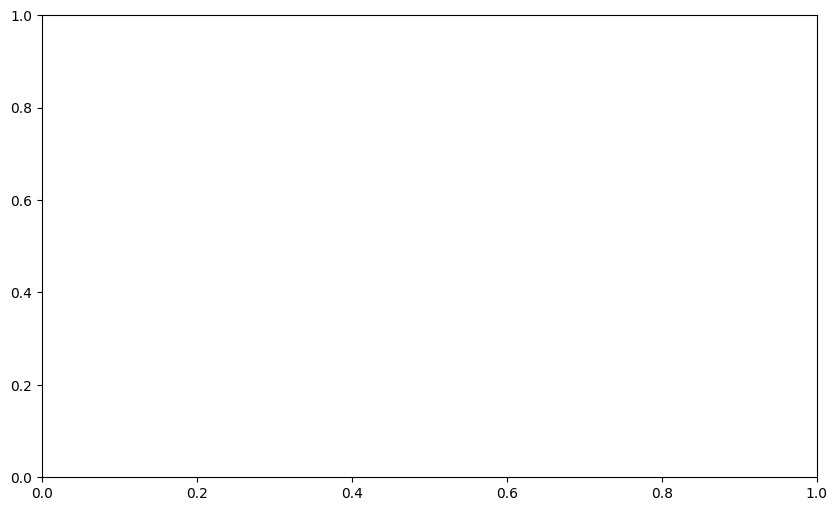

In [24]:
import itertools
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
from scipy.optimize import minimize
from scipy.stats import beta
import matplotlib.pyplot as plt

# ---------------------------
# SHAPLEY VALUE FUNCTIONS
# ---------------------------

def kpi_score(kpi_subset, data_AsIs, data_ToBe):
    """
    Score function: sum of % improvements of KPIs in subset.
    data_AsIs, data_ToBe: dict or dataframe with KPI values
    kpi_subset: set or list of KPI names to consider
    """
    improvement_sum = 0.0
    for kpi in kpi_subset:
        if data_AsIs[kpi] == 0:
            continue
        improvement = (data_ToBe[kpi] - data_AsIs[kpi]) / data_AsIs[kpi]
        improvement_sum += improvement
    return improvement_sum

def compute_shapley_values(kpis, data_AsIs, data_ToBe):
    n = len(kpis)
    shapley_vals = dict.fromkeys(kpis, 0.0)
    
    for kpi in kpis:
        contributions = []
        others = [x for x in kpis if x != kpi]
        
        for i in range(n):
            subsets = list(itertools.combinations(others, i))
            for subset in subsets:
                subset = set(subset)
                with_kpi = subset | {kpi}
                
                score_without = kpi_score(subset, data_AsIs, data_ToBe)
                score_with = kpi_score(with_kpi, data_AsIs, data_ToBe)
                
                marginal_contrib = score_with - score_without
                
                weight = (np.math.factorial(len(subset)) * np.math.factorial(n - len(subset) - 1)) / np.math.factorial(n)
                contributions.append(weight * marginal_contrib)
        
        shapley_vals[kpi] = sum(contributions)
    
    total = sum(shapley_vals.values())
    for k in shapley_vals:
        shapley_vals[k] /= total if total != 0 else 1
    
    return shapley_vals

# ---------------------------
# CONFIGURATION
# ---------------------------
KPI_IMPROVEMENTS: Dict[str, float] = {
    'Valore medio della merce consegnata in un giro [€/giro]': 0.05,
    '# giorni lavorati nel mese': 0.0,
    '# clienti  serviti nel mese': 0.06,
    'Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]': -0.40,
    '# consegne ripianificate per problemi nel TRASPORTO': -0.50,
    '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)': -0.30,
    '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)': -0.30,
    '# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)': -0.25,
    '# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)': -0.15
}

RI_DICT: Dict[int, float] = {
    1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12,
    6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49
}

# ---------------------------
# FUNCTIONS
# ---------------------------

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    # Drop 'Unnamed: 14' column if it exists
    if 'Unnamed: 14' in df.columns:
        df = df.drop(columns=['Unnamed: 14'])
    
    # Identify columns to convert to numeric (all except some categorical columns)
    numeric_cols = [
        col for col in df.columns 
        if col not in ['Id', 'Mese', 'Id Equipaggio', 'Classe']
    ]
    
    # Convert numeric columns that might be strings with commas as decimal separator
    for col in numeric_cols:
        if df[col].dtype == object:
            df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='coerce')
    
    # Return dataframe unchanged otherwise (no dropping rows)
    return df


def compute_indicator(df: pd.DataFrame) -> pd.Series:
    total_rescheduling = (
        df['# consegne ripianificate per problemi nel TRASPORTO'] +
        df['# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)'] +
        df['# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)'] +
        df['# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)'] +
        df['# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)']
    )
    
    abs_delta = np.abs(df['Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]'])
    denominator = (abs_delta + 1e-5) * (total_rescheduling + 1)
    
    numerator = (
        df['# clienti  serviti nel mese'] *
        df['UPL'] *
        df['Valore medio della merce consegnata in un giro [€/giro]']
    )
    
    return numerator / denominator

def fit_beta_distribution(data: pd.Series) -> Tuple[float, float]:
    # Normalizza in [0,1] per fit Beta
    data_min, data_max = data.min(), data.max()
    if data_max == data_min:
        return 2.0, 2.0  # caso costante
    
    data_norm = (data - data_min) / (data_max - data_min)
    filtered_data = data_norm[(data_norm > 0) & (data_norm < 1)]
    
    if len(filtered_data) < 10:
        m = filtered_data.mean() if len(filtered_data) > 0 else 0.5
        m = np.clip(m, 0.01, 0.99)
        k = 2.0
        alpha_fb = m * k + 1
        beta_fb = (1 - m) * k + 1
        return alpha_fb, beta_fb

    def negative_log_likelihood(params: List[float]) -> float:
        a, b = params
        if a <= 0 or b <= 0:
            return np.inf
        return -np.sum(beta.logpdf(filtered_data, a, b))

    result = minimize(negative_log_likelihood, x0=[2, 2], bounds=[(0.01, 10), (0.01, 10)])
    if result.success:
        return result.x
    else:
        return 2.0, 2.0

def simulate_from_beta(alpha: float, beta_param: float, size: int, data_min=0, data_max=1) -> np.ndarray:
    samples = beta.rvs(alpha, beta_param, size=size)
    return samples * (data_max - data_min) + data_min

def apply_improvements(df: pd.DataFrame, improvements: Dict[str, float]) -> pd.DataFrame:
    df_improved = df.copy()
    for kpi, change in improvements.items():
        if kpi in df_improved.columns:
            df_improved[kpi] = df_improved[kpi] * (1 + change)
    return df_improved

def plot_distributions(real_data: pd.Series, sim_data_as_is: np.ndarray, sim_data_to_be: np.ndarray, title: str) -> None:
    plt.figure(figsize=(10, 6))
    plt.hist(real_data, bins=50, alpha=0.4, label="Real", density=True)
    plt.hist(sim_data_as_is, bins=50, alpha=0.4, label="Simulated As-Is", density=True)
    plt.hist(sim_data_to_be, bins=50, alpha=0.4, label="Simulated To-Be", density=True)
    plt.title(title)
    plt.xlabel("Acceptance Rate")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def prepare_shap_data(df_as_is: pd.DataFrame, df_to_be: pd.DataFrame, kpi_list: List[str]) -> Tuple[Dict[str, float], Dict[str, float]]:
    data_AsIs = {}
    data_ToBe = {}
    for kpi in kpi_list:
        if kpi in df_as_is.columns and kpi in df_to_be.columns:
            data_AsIs[kpi] = df_as_is[kpi].mean()
            data_ToBe[kpi] = df_to_be[kpi].mean()
        else:
            data_AsIs[kpi] = 0
            data_ToBe[kpi] = 0
    return data_AsIs, data_ToBe

def run_shapley_analysis(df_clean: pd.DataFrame, df_after: pd.DataFrame) -> Dict[str, float]:
    shap_kpis = list(KPI_IMPROVEMENTS.keys())
    data_AsIs, data_ToBe = prepare_shap_data(df_clean, df_after, shap_kpis)
    shapley_weights = compute_shapley_values(shap_kpis, data_AsIs, data_ToBe)
    
    print("\n--- Shapley Values for KPIs ---")
    for kpi, weight in shapley_weights.items():
        print(f"{kpi}: {weight:.4f}")
    return shapley_weights

# ---------------------------
# MAIN PIPELINE
# ---------------------------

def main_ahp_shapley(path_to_excel: str):
    df = pd.read_csv(path_to_excel)
    df.columns = [col.replace("\n", " ") for col in df.columns]
    print(df.info())
    
    df_clean = clean_data(df)
    
    indicator = compute_indicator(df_clean)
    print(f"Indicator stats: mean={indicator.mean():.4f}, min={indicator.min():.4f}, max={indicator.max():.4f}")
    
    data_min, data_max = indicator.min(), indicator.max()
    alpha_fb, beta_fb = fit_beta_distribution(indicator)
    print(f"Fitted Beta params: alpha={alpha_fb:.4f}, beta={beta_fb:.4f}")
    
    size = len(indicator)
    sim_data_as_is = simulate_from_beta(alpha_fb, beta_fb, size, data_min, data_max)
    
    df_after = apply_improvements(df_clean, KPI_IMPROVEMENTS)
    indicator_to_be = compute_indicator(df_after)
    sim_data_to_be = simulate_from_beta(alpha_fb, beta_fb, size, data_min, data_max)
    
    plot_distributions(indicator, sim_data_as_is, sim_data_to_be, "Acceptance Rate Distribution: Real vs Simulated As-Is & To-Be")
    
    shapley_weights = run_shapley_analysis(df_clean, df_after)
    
    return {
        "df_clean": df_clean,
        "df_after": df_after,
        "sim_data_as_is": sim_data_as_is,
        "sim_data_to_be": sim_data_to_be,
        "shapley_weights": shapley_weights
    }
    
#TODO: based on pct change, normalize all of them , fit it to 1, 3 or 5 punteggio

# ---------------------------
# ESEMPIO USO
# ---------------------------

if __name__ == "__main__":
    results = main_ahp_shapley("dataset.csv")
